# Python 與 BigQuery 操作練習
#### 透過 Python 與 BigQuery 繪製「家用快篩試劑社區定點診所的地理分布圖」

## 一、處理資料

### 從「政府資料開放平台」下載「配合辦理發放公費COVID-19家用快篩試劑社區定點診所名單」csv 資料

資料來源：https://data.gov.tw/dataset/150692

In [13]:
import pandas as pd

covid19_clinic_datasets = pd.read_csv("./data/covid19_free_rapid_antigen_test_clinics.csv")
print(covid19_clinic_datasets.head())

   序號  縣市別 鄉鎮市區別                診所名稱                診所地址         診所電話  \
0   1  臺北市   士林區             粱耳鼻喉科診所      臺北市士林區社正路12-1號  02-28168456   
1   2  臺北市   大同區            大同耳鼻喉科診所  臺北市大同區重慶北路三段250之4號  02-25975833   
2   3  臺北市   大同區                建順診所        臺北市大同區甘州街51號  02-25573250   
3   4  臺北市   大同區              施小兒科診所     臺北市大同區重慶北路三段28號  02-25941935   
4   5  臺北市   大安區  尹書田醫療財團法人書田泌尿科眼科診所    臺北市大安區建國南路二段276號  02-23690211   

         Long        Lat  
0  121.509303  25.088550  
1  121.513575  25.071148  
2  121.512854  25.059677  
3  121.513461  25.065090  
4  121.537266  25.025172  


**檢視資料**

In [14]:
covid19_clinic_datasets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   序號      540 non-null    int64  
 1   縣市別     540 non-null    object 
 2   鄉鎮市區別   540 non-null    object 
 3   診所名稱    540 non-null    object 
 4   診所地址    540 non-null    object 
 5   診所電話    540 non-null    object 
 6   Long    540 non-null    float64
 7   Lat     540 non-null    float64
dtypes: float64(2), int64(1), object(5)
memory usage: 33.9+ KB


**上傳至Google BigQuery**

In [15]:
from google.cloud import bigquery as bq
import pyarrow
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="./william-336203-645ef4690b93.json"
client = bq.Client()
print(client)

**建立資料集和資料表**

In [18]:
# 資料集名稱
dataset_id = f"{client.project}.covid19_dataset"

# 資料表名稱
table_id = f"{dataset_id}.clinic_dataTable"

# 設定資料表欄位格式
tschema = [
bq.SchemaField("series_code", "STRING"),
bq.SchemaField("county", "STRING", mode="NULLABLE"),
bq.SchemaField("township_dist", "STRING", mode="NULLABLE"),
bq.SchemaField("clinic_name", "STRING", mode="NULLABLE"),
bq.SchemaField("clinic_address", "STRING", mode="NULLABLE"),
bq.SchemaField("Long", "FLOAT", mode="NULLABLE"),
bq.SchemaField("Lat", "FLOAT", mode="NULLABLE"),
]


dataset = bq.Dataset(dataset_id)
dataset.location = "asia-east1"
dataset = client.create_dataset(dataset)
table = bq.Table(table_id, schema=tschema)

table = client.create_table(table)  # API request
print(f"Created dataset {client.project}.{dataset.dataset_id}")
print(f"Created table {table.project}.{table.dataset_id}.{table.table_id}")

Created dataset william-336203.covid19_dataset
Created table william-336203.covid19_dataset.clinic_dataTable


**上傳至資料表**

In [19]:
# 指定資料集
dataset_id = "covid19_dataset"
dataset_ref = client.dataset(dataset_id)

# 指定資料表
table_ref = dataset_ref.table("clinic_dataTable")

upload_df = covid19_clinic_datasets.loc[:,['序號', '縣市別', '鄉鎮市區別', '診所名稱', '診所地址', 'Long', 'Lat']]
# 將欄位轉成對應的英文名稱
upload_df.columns = ["series_code","county","township_dist","clinic_name","clinic_address","Long","Lat"]
upload_df.loc[:,"series_code"] = upload_df.loc[:,"series_code"].astype(str)

bq_request = client.load_table_from_dataframe(upload_df, table_ref, location="asia-east1")
bq_request.result()

LoadJob<project=william-336203, location=asia-east1, id=e074a3a8-584e-4c8c-a91d-5a07630eca6e>

## 二、BigQurey 繪圖

### 搜尋所有資料
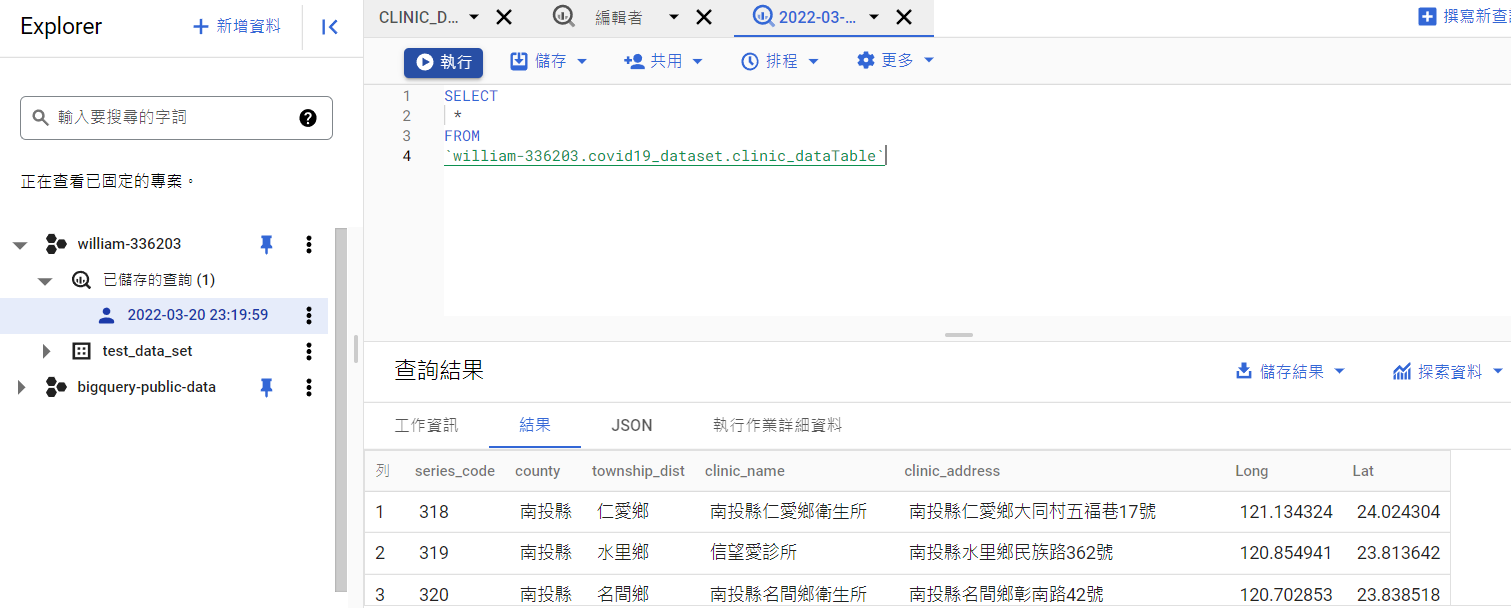

**利用「探索資料」繪製「台灣之家用快篩試劑社區定點診所的地理分布圖」**

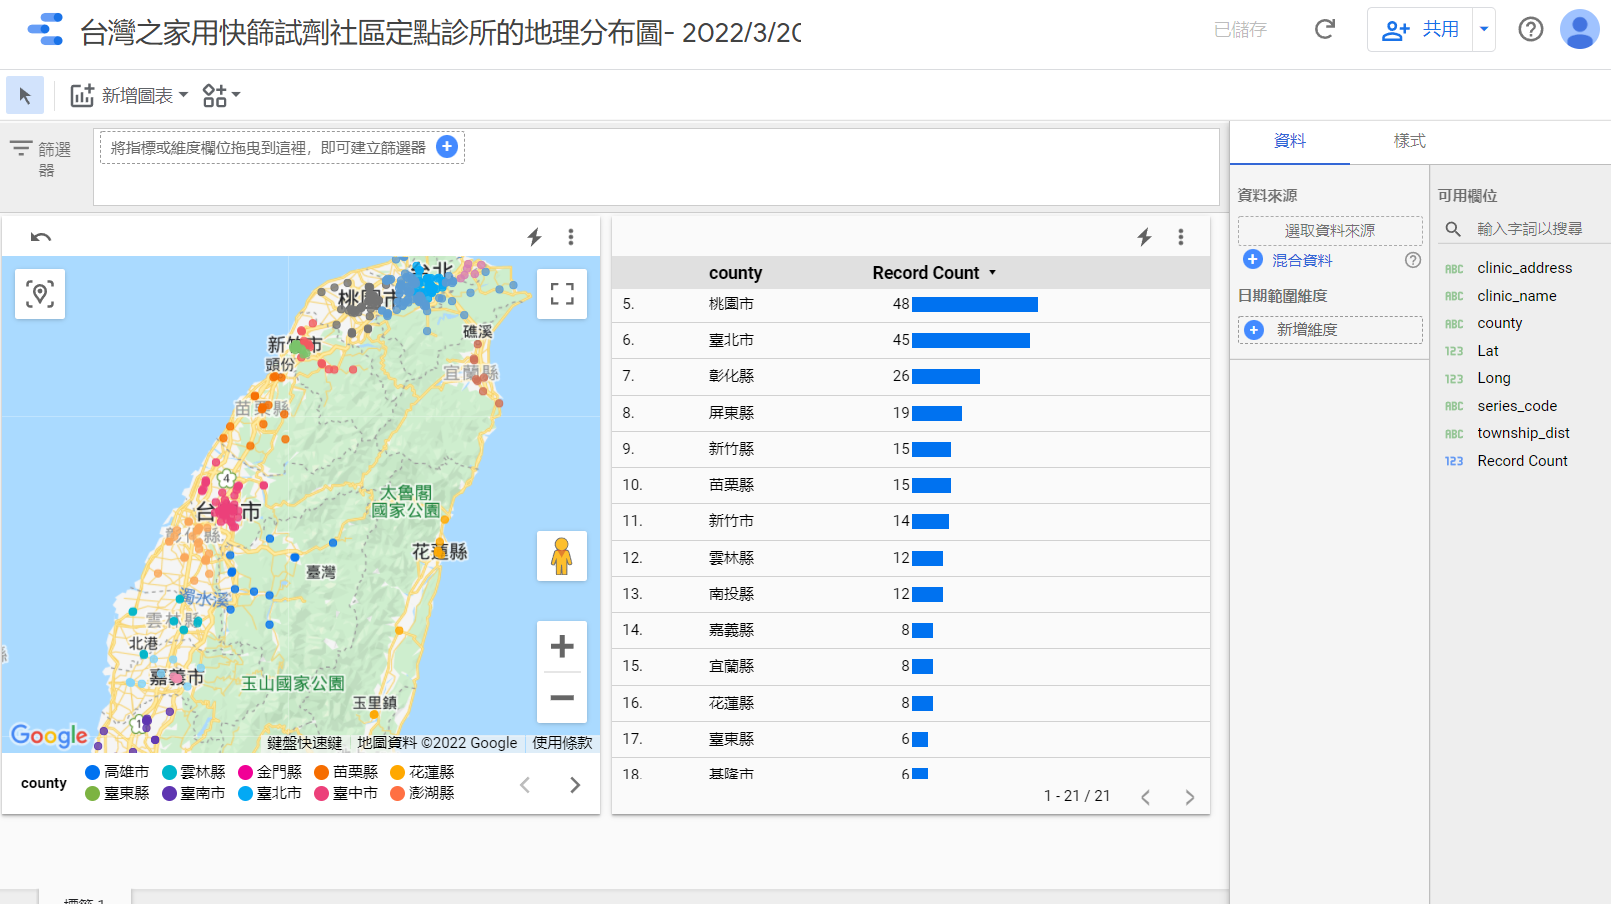
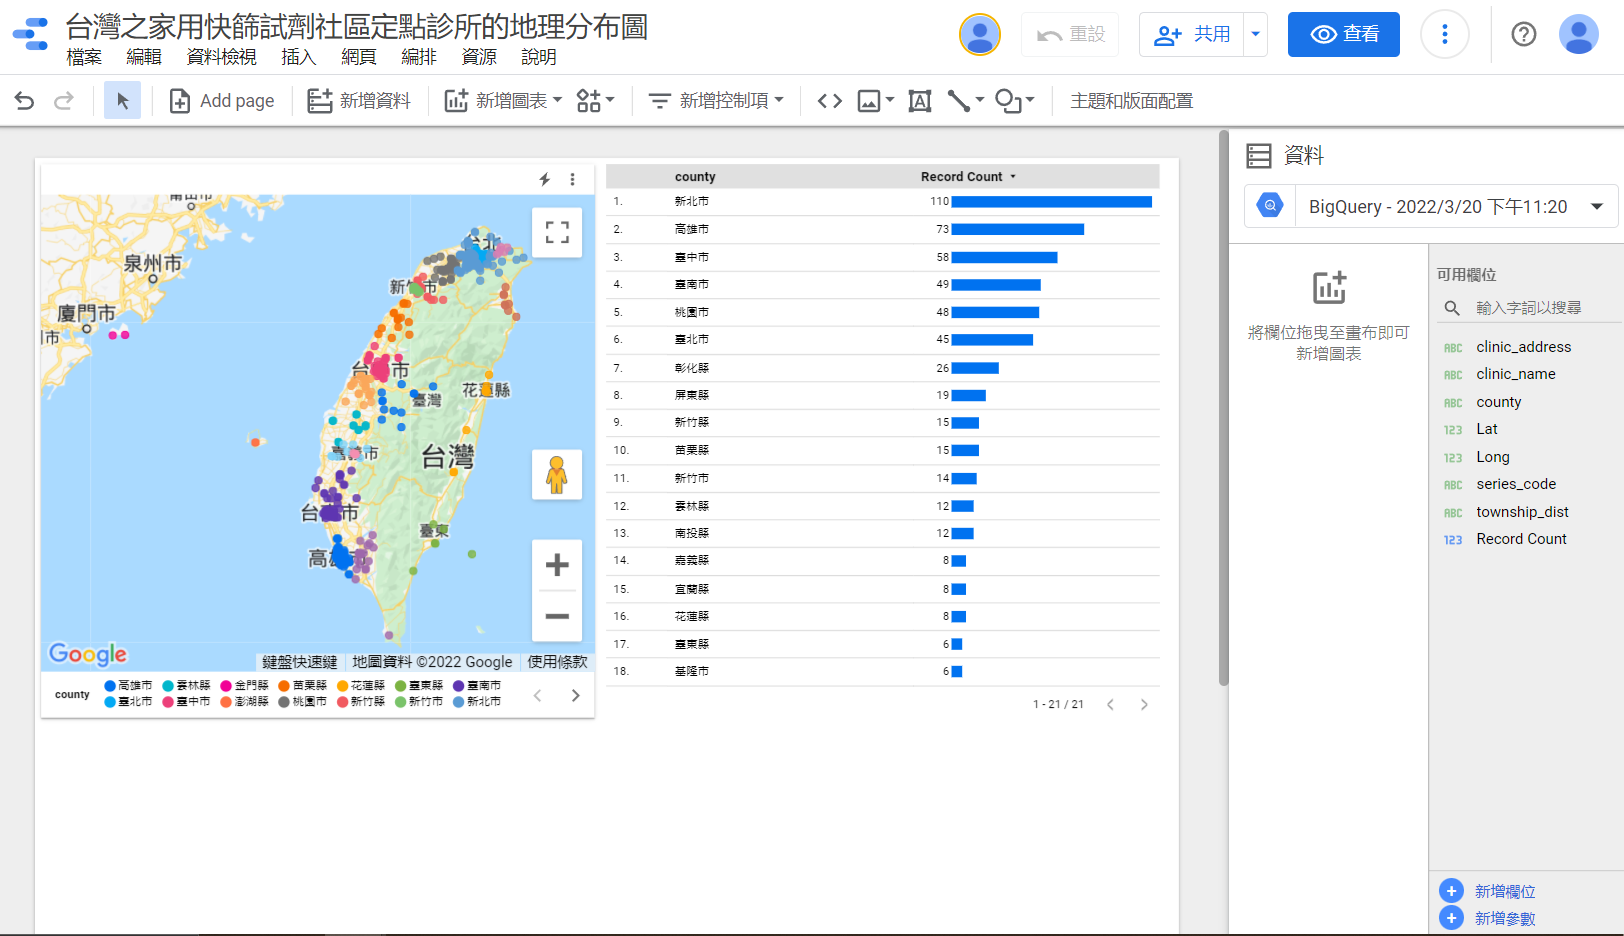

報表連結：https://datastudio.google.com/reporting/f10bd6fa-c6c8-4c64-a34a-3392efd4ce01/page/0PUoC